In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src')
from preprocessing import *
from utils import *
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from plotting import *

# Smote libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

ModuleNotFoundError: No module named 'imblearn'

In [3]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [5]:
df_train, df_test = split_series_byID(0.75, df_db)

In [6]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

## Radial Basis Function

In [7]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(xtrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = rbf_feature.fit_transform(xtest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7658983203295701
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.66436468094514


(0.7658983203295701, 1.0, 0.0, 0.0, 0.66436468094514)

## Additive Chi 2

In [8]:
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_transformed, ytrain)

X_features = chi2sampler.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7511635504304182
Recall on background: 0.9407887083640312
Recall on banana: 0.015528125352271447
Recall on wine: 0.3384279475982533
F1-score: 0.6966520774385728


(0.7511635504304182,
 0.9407887083640312,
 0.015528125352271447,
 0.3384279475982533,
 0.6966520774385728)

## Skewed Chi 2

In [9]:
chi2_feature = SkewedChi2Sampler(skewedness=.01, n_components=10, random_state=0)
X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = chi2_feature.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7613035158951383
Recall on background: 0.9569417747323056
Recall on banana: 0.0
Recall on wine: 0.3396973697572865
F1-score: 0.6932812480702728


(0.7613035158951383,
 0.9569417747323056,
 0.0,
 0.3396973697572865,
 0.6932812480702728)

## Hiperparámetros SKEWED

In [3]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [4]:
SKEW = [.0001, .001, .01, .05, .1]
NCOMP = [20, 40, 80, 100, 200, 500]

In [11]:
N_reps = 10
for skew in SKEW:
    for ncomp in NCOMP:
        ACC = []
        F1 = []    
        for i in range(N_reps):
            df_train, df_test = split_series_byID(0.75, df_db)
            features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
            xtrain, ytrain = df_train[features].values, df_train['class'].values
            xtest, ytest = df_test[features].values, df_test['class'].values

            chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
            clf = SGDClassifier(max_iter=500, tol=1e-4)

            start_t = time.time()
            X_features = chi2_feature.fit_transform(xtrain, ytrain)
            clf.fit(X_features, ytrain)
            end_t = time.time()

            X_features = chi2_feature.fit_transform(xtest, ytest)

            y_pred = clf.predict(X_features)
            occurrences_dict = Counter(ytest)


            ACC.append(accuracy_score(ytest, y_pred))
            F1.append(f1_score(ytest, y_pred, average='weighted'))

        print("\n\n")    
        print("Skew: %.4f" % (skew) + " Ncomp: %d" % (ncomp))
        print("Accuracy: %.4f" % (np.mean(ACC)) + " +- %.2f"  % (np.std(ACC)))
        print("F1-Score: %.4f" % (np.mean(F1)) + " +- %.2f"  % (np.std(F1)))




Skew: 0.0001 Ncomp: 20
Accuracy: 0.8283 +- 0.03
F1-Score: 0.7824 +- 0.04



Skew: 0.0001 Ncomp: 40
Accuracy: 0.8267 +- 0.03
F1-Score: 0.7774 +- 0.03



Skew: 0.0001 Ncomp: 80
Accuracy: 0.8202 +- 0.04
F1-Score: 0.7694 +- 0.05



Skew: 0.0001 Ncomp: 100
Accuracy: 0.8364 +- 0.02
F1-Score: 0.7914 +- 0.03



Skew: 0.0001 Ncomp: 200
Accuracy: 0.8255 +- 0.02
F1-Score: 0.7747 +- 0.02



Skew: 0.0001 Ncomp: 500
Accuracy: 0.7928 +- 0.01
F1-Score: 0.7314 +- 0.01



Skew: 0.0010 Ncomp: 20
Accuracy: 0.7976 +- 0.01
F1-Score: 0.7394 +- 0.02



Skew: 0.0010 Ncomp: 40
Accuracy: 0.8205 +- 0.03
F1-Score: 0.7660 +- 0.04



Skew: 0.0010 Ncomp: 80
Accuracy: 0.8219 +- 0.01
F1-Score: 0.7629 +- 0.01



Skew: 0.0010 Ncomp: 100
Accuracy: 0.8184 +- 0.04
F1-Score: 0.7632 +- 0.05



Skew: 0.0010 Ncomp: 200
Accuracy: 0.8572 +- 0.02
F1-Score: 0.7982 +- 0.02



Skew: 0.0010 Ncomp: 500
Accuracy: 0.8319 +- 0.03
F1-Score: 0.7871 +- 0.04



Skew: 0.0100 Ncomp: 20
Accuracy: 0.8215 +- 0.03
F1-Score: 0.7716 +- 0.04



Ske

## Clean-DB(Simple y Bagging) 

In [3]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

### Simple

In [23]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, df_db)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))
    
end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))

>===============================================================<
Iteración 1 de 10
Training time (mins): 0.47837392886479696
>===============================================================<
>===============================================================<
Iteración 2 de 10
Training time (mins): 0.4712234059969584
>===============================================================<
>===============================================================<
Iteración 3 de 10
Training time (mins): 0.4912343740463257
>===============================================================<
>===============================================================<
Iteración 4 de 10
Training time (mins): 0.5579444130261739
>===============================================================<
>===============================================================<
Iteración 5 de 10
Training time (mins): 0.4395057757695516
>===============================================================<
>===========================================

### Bagging

In [10]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, df_db)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
    bc = BaggingClassifier(base_estimator=clf, n_estimators=500, n_jobs=-1)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = bc.fit(X_features, ytrain)
    end_t = time.time()


    X_features = chi2_feature.fit_transform(xtest, ytest)

    print('\n>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))

end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))


>===============================================================<
Iteración 1 de 10
Training time (mins): 13.144657599925996
>===============================================================<

>===============================================================<
Iteración 2 de 10
Training time (mins): 12.189799276987712
>===============================================================<

>===============================================================<
Iteración 3 de 10
Training time (mins): 12.457389295101166
>===============================================================<

>===============================================================<
Iteración 4 de 10
Training time (mins): 12.727285075187684
>===============================================================<

>===============================================================<
Iteración 5 de 10
Training time (mins): 13.58463815053304
>===============================================================<

>=======================================

## WINDOWS-120 (Simple y Ensembles)

In [3]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
win_df = window_df(df_db, window_size=120)

In [17]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))
    
end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))

>===============================================================<
Iteración 1 de 10
Training time (mins): 0.43666475216547646
>===============================================================<
>===============================================================<
Iteración 2 de 10
Training time (mins): 0.4774594267209371
>===============================================================<
>===============================================================<
Iteración 3 de 10
Training time (mins): 0.47031120856602987
>===============================================================<
>===============================================================<
Iteración 4 de 10
Training time (mins): 0.44652271270751953
>===============================================================<
>===============================================================<
Iteración 5 de 10
Training time (mins): 0.4539390762646993
>===============================================================<
>=========================================

### Bagging

In [16]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
    bc = BaggingClassifier(base_estimator=clf, n_estimators=500, n_jobs=-1)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = bc.fit(X_features, ytrain)
    end_t = time.time()


    X_features = chi2_feature.fit_transform(xtest, ytest)

    print('\n>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))

end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))


>===============================================================<
Iteración 1 de 10
Training time (mins): 11.790259532133739
>===============================================================<

>===============================================================<
Iteración 2 de 10
Training time (mins): 11.738831476370494
>===============================================================<

>===============================================================<
Iteración 3 de 10
Training time (mins): 11.66119594971339
>===============================================================<

>===============================================================<
Iteración 4 de 10
Training time (mins): 12.063853216171264
>===============================================================<

>===============================================================<
Iteración 5 de 10
Training time (mins): 11.381752387682598
>===============================================================<

>=======================================

## Probando Smote en W-120 sin bagging

In [5]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values
    
    # SMOTE
    oversample = SMOTE(sampling_strategy=over_dict)
    undersample = RandomUnderSampler(sampling_strategy=under_dict)
    xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)
    xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)
    
    chi2_feature = SkewedChi2Sampler(skewedness=.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))
    
end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))

>===============================================================<
Iteración 1 de 10
Training time (mins): 0.5478445291519165
>===============================================================<
>===============================================================<
Iteración 2 de 10
Training time (mins): 0.5675431847572326
>===============================================================<
>===============================================================<
Iteración 3 de 10
Training time (mins): 0.5563404162724813
>===============================================================<
>===============================================================<
Iteración 4 de 10
Training time (mins): 0.5724073847134908
>===============================================================<
>===============================================================<
Iteración 5 de 10
Training time (mins): 0.5283244649569193
>===============================================================<
>============================================

## Probando Smote en W-120 con Bagging

In [4]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}
N_reps = 10
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values
    
    # SMOTE
    oversample = SMOTE(sampling_strategy=over_dict)
    undersample = RandomUnderSampler(sampling_strategy=under_dict)
    xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)
    xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
    bc = BaggingClassifier(base_estimator=clf, n_estimators=500, n_jobs=-1)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = bc.fit(X_features, ytrain)
    end_t = time.time()


    X_features = chi2_feature.fit_transform(xtest, ytest)

    print('\n>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))

end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))


>===============================================================<
Iteración 1 de 10
Training time (mins): 15.006170757611592
>===============================================================<

>===============================================================<
Iteración 2 de 10
Training time (mins): 14.721784778436025
>===============================================================<

>===============================================================<
Iteración 3 de 10
Training time (mins): 13.587527914841969
>===============================================================<

>===============================================================<
Iteración 4 de 10
Training time (mins): 13.831494096914927
>===============================================================<

>===============================================================<
Iteración 5 de 10
Training time (mins): 13.628861423333486
>===============================================================<

>======================================

In [2]:
win_df = pd.read_pickle('../datasets/preprocessed/window120_dataset.pkl')

In [32]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

df_train, df_test = split_series_byID(0.8, win_df)


xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

In [24]:
chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
bc = BaggingClassifier(base_estimator=clf, n_estimators=100, n_jobs=-1)

X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = bc.fit(X_features, ytrain)


X_features = chi2_feature.fit_transform(xtest, ytest)


y_pred = clf.predict(X_features)
metric_report(ytest, y_pred)

TEST SET PROPORTIONS:
	Real background percentage: 0.7671455216695185
	Real banana percentage: 0.13163469103673667
	Real wine percentage: 0.10121978729374481
------------------------------------------
Accuracy: 0.8277277403949316
Recall on background: 0.952908607124671
Recall on banana: 0.0980146290491118
Recall on wine: 0.8279610806109692
F1-score: 0.7892141648590308


In [25]:
probs = clf.predict_proba(X_features)

In [26]:
test_ids = list(set(df_test['id']))
print(test_ids)

[15, 17, 20, 21, 22, 24, 25, 27, 30, 47, 49, 60, 65, 67, 71, 85, 88, 91, 96, 99]


In [27]:
# SMOTE
over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}

oversample = SMOTE(sampling_strategy=over_dict)
undersample = RandomUnderSampler(sampling_strategy=under_dict)
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

chi2_feature_smote = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
clf_smote = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
bc_smote = BaggingClassifier(base_estimator=clf_smote, n_estimators=100, n_jobs=-1)

X_features_smote = chi2_feature_smote.fit_transform(xtrain, ytrain)
clf_sm = bc_smote.fit(X_features_smote, ytrain)


X_features_smote = chi2_feature_smote.fit_transform(xtest, ytest)


y_pred_smote = clf_sm.predict(X_features_smote)
metric_report(ytest, y_pred_smote)

TEST SET PROPORTIONS:
	Real background percentage: 0.7671455216695185
	Real banana percentage: 0.13163469103673667
	Real wine percentage: 0.10121978729374481
------------------------------------------
Accuracy: 0.8073979521658514
Recall on background: 0.8952887091105995
Recall on banana: 0.26039707419017766
Recall on wine: 0.8526390172310703
F1-score: 0.7966912670130065


In [28]:
probs_smote = clf_sm.predict_proba(X_features_smote)

In [29]:
test_ids_sm = list(set(df_test['id']))
print(test_ids_sm)

[15, 17, 20, 21, 22, 24, 25, 27, 30, 47, 49, 60, 65, 67, 71, 85, 88, 91, 96, 99]


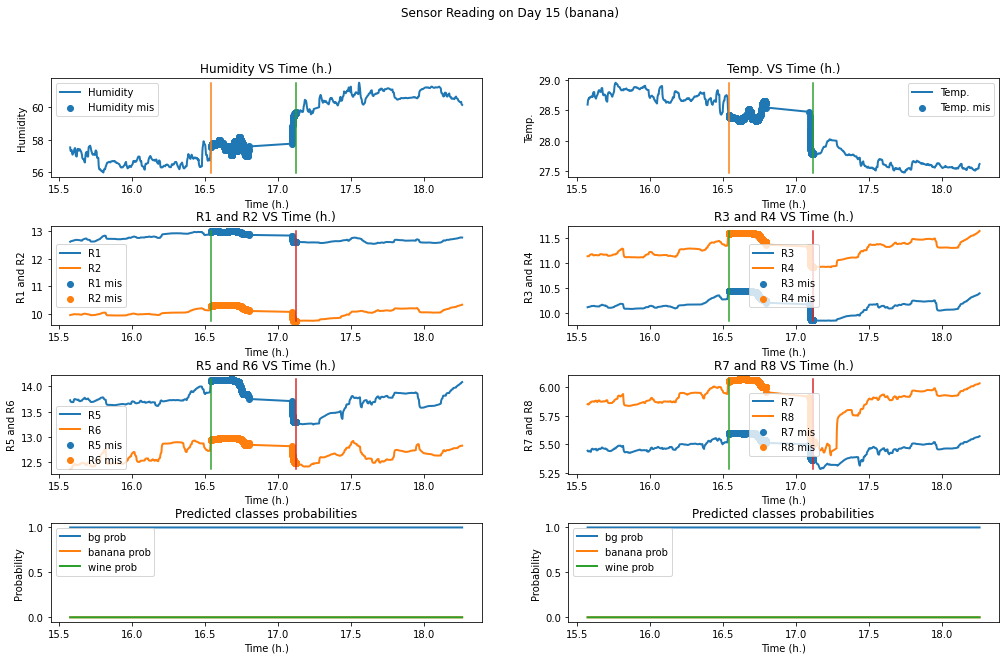

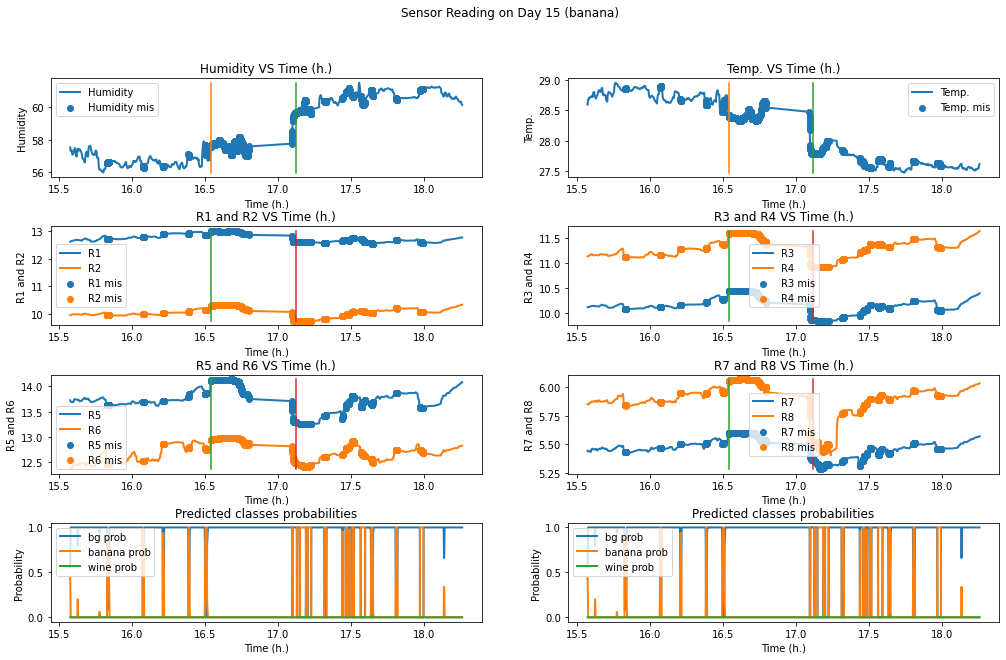

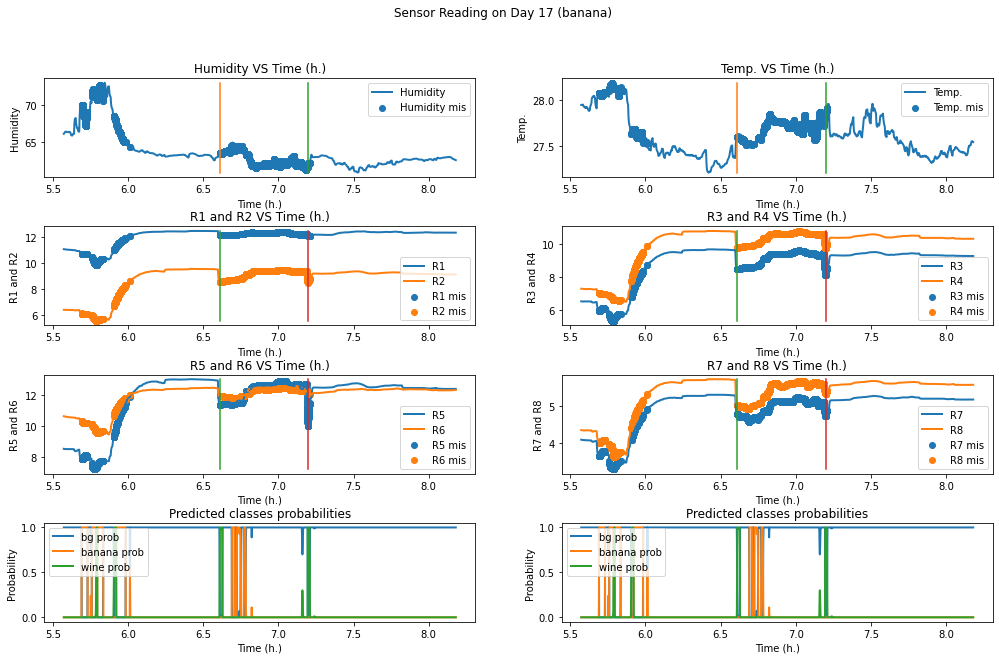

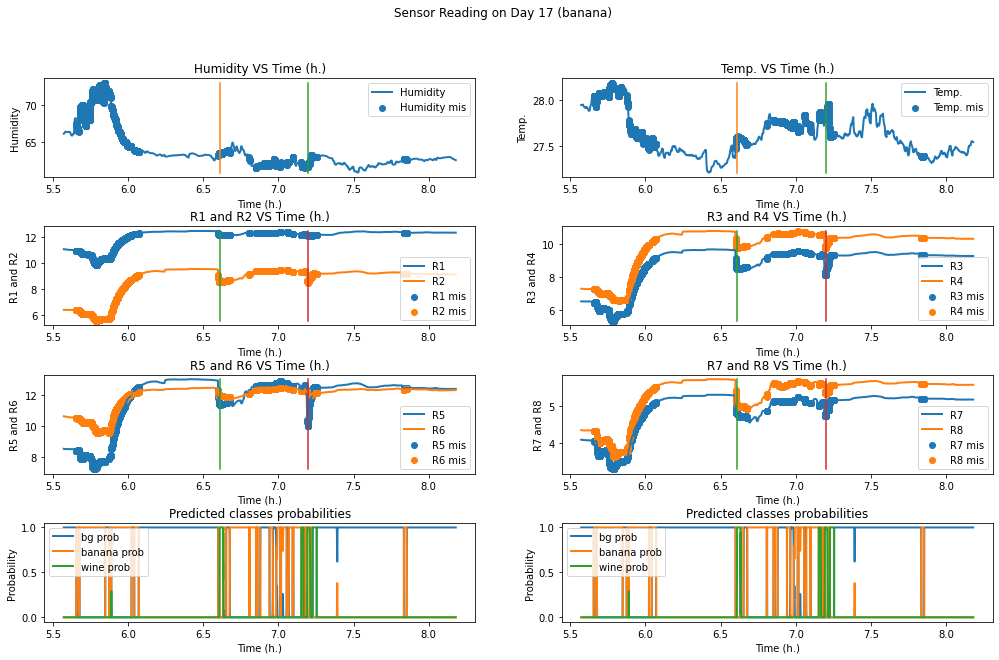

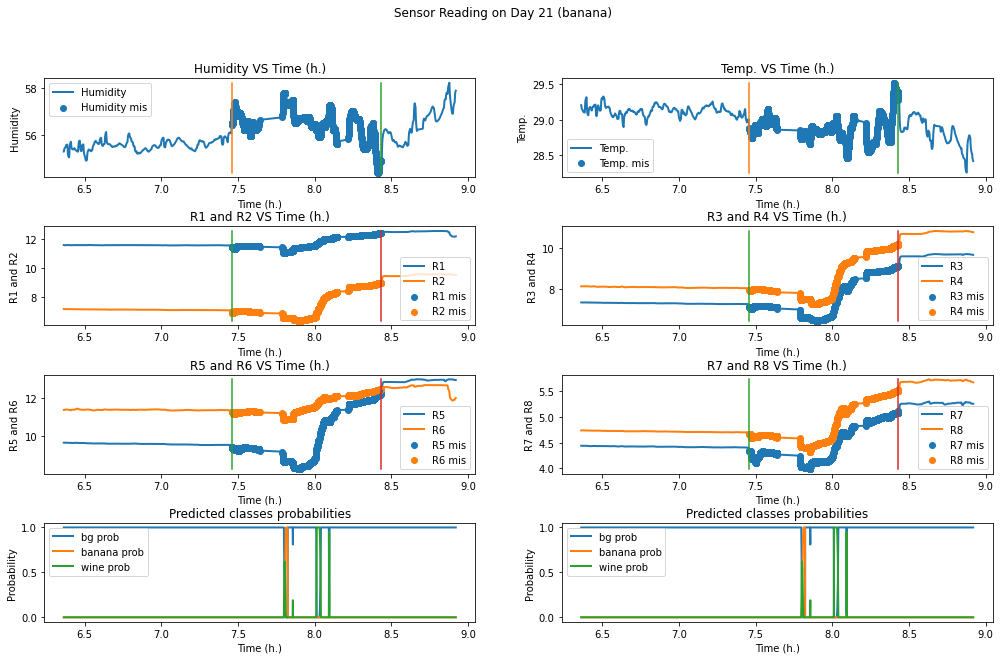

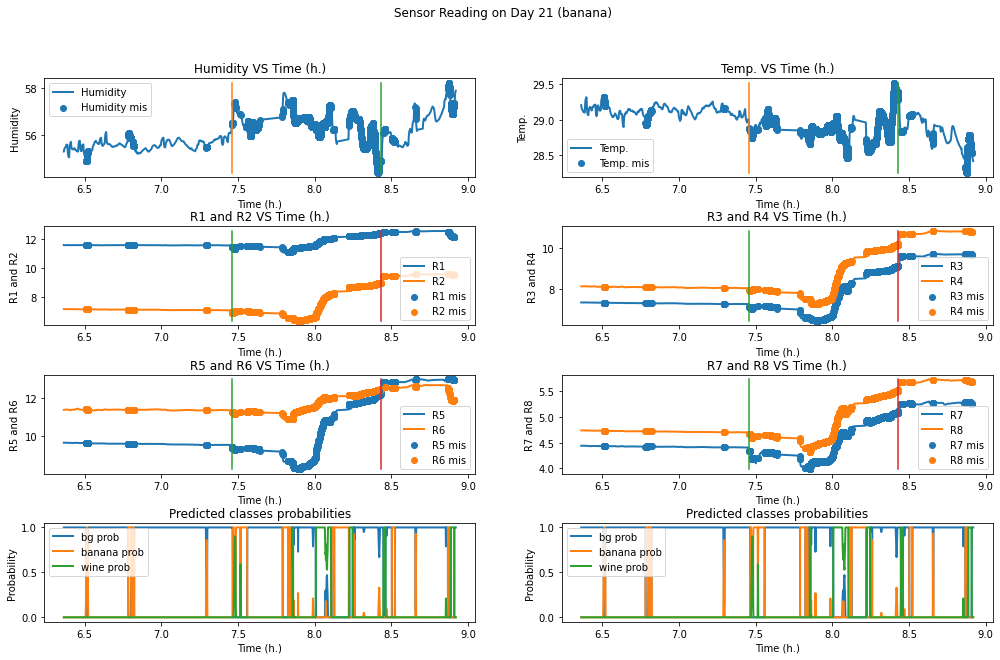

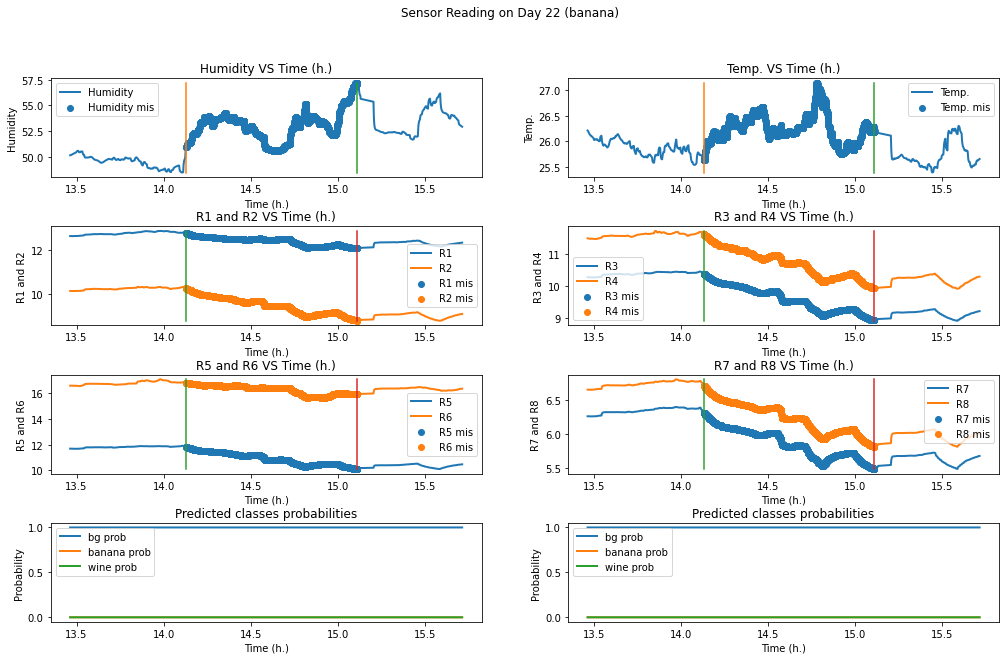

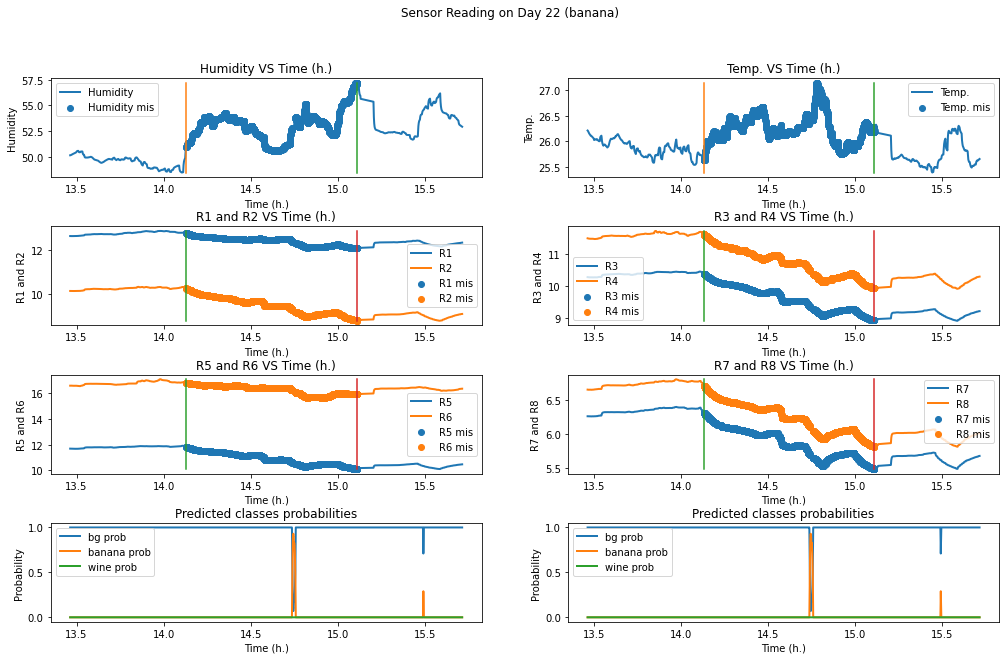

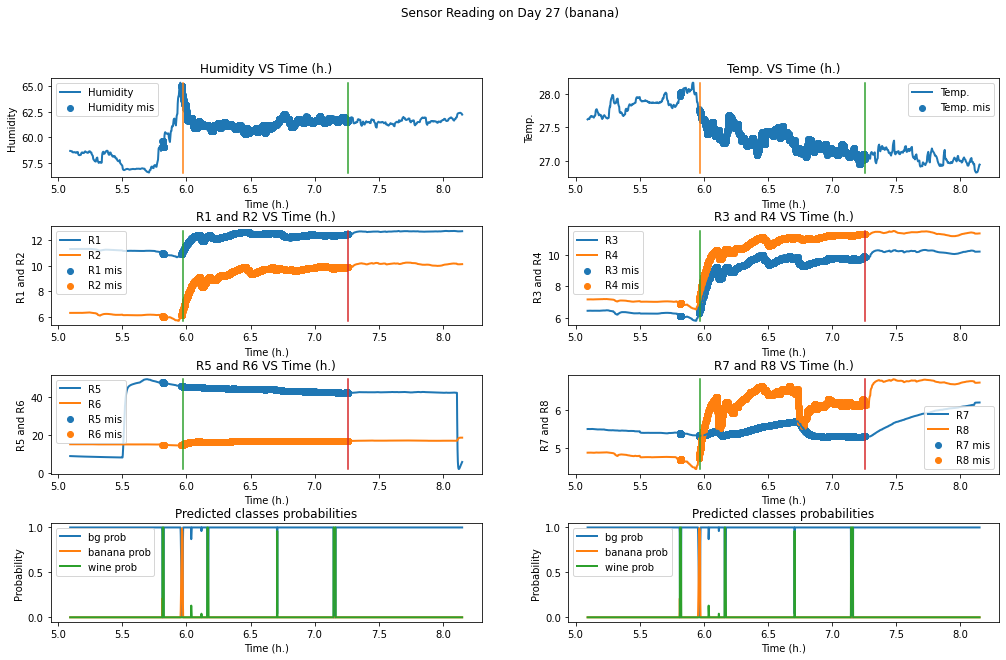

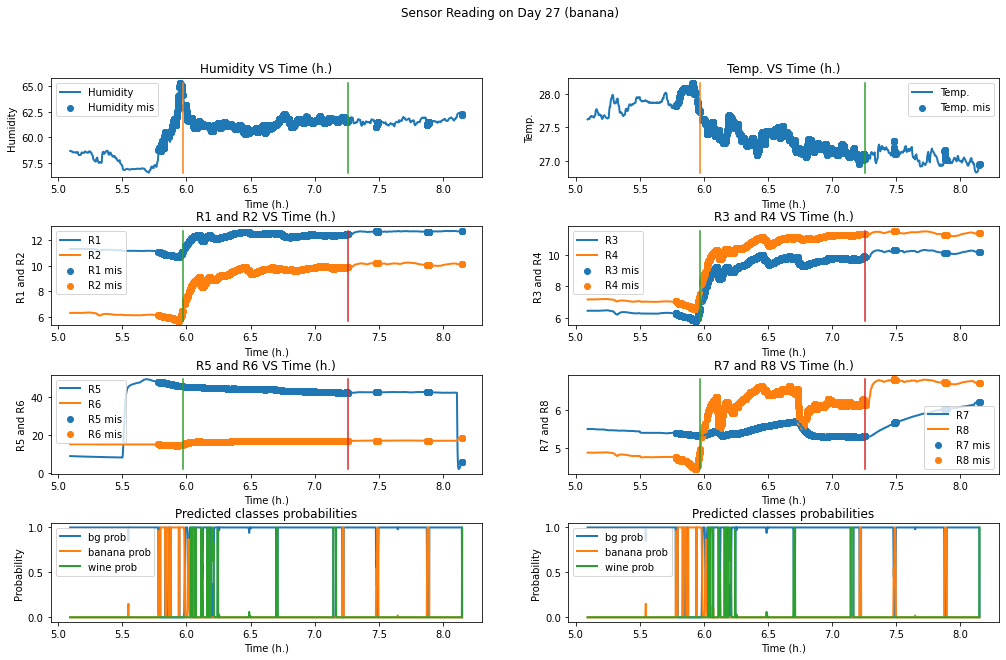

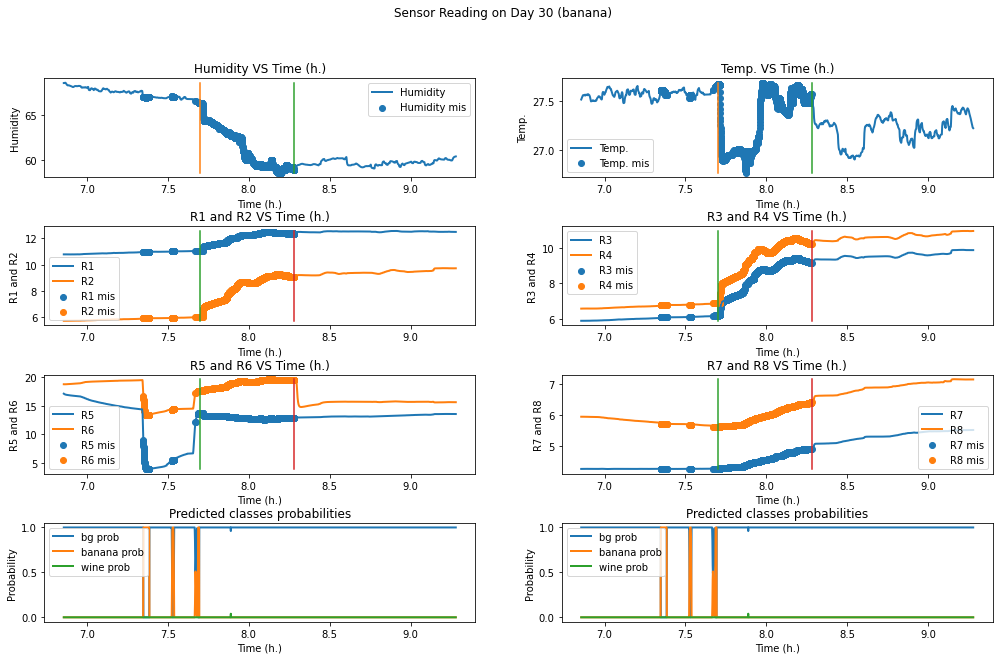

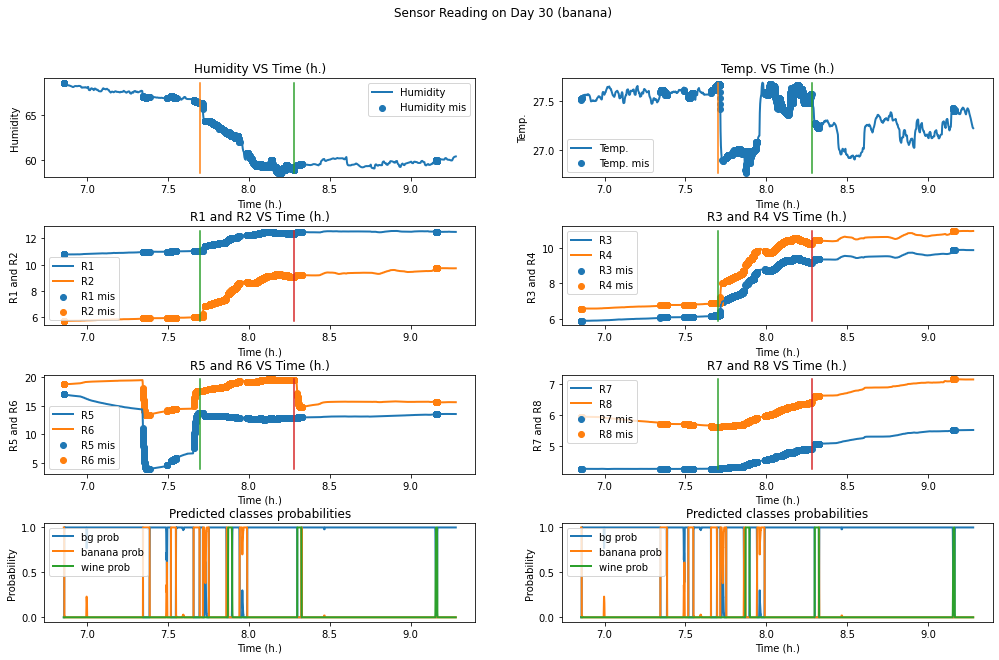

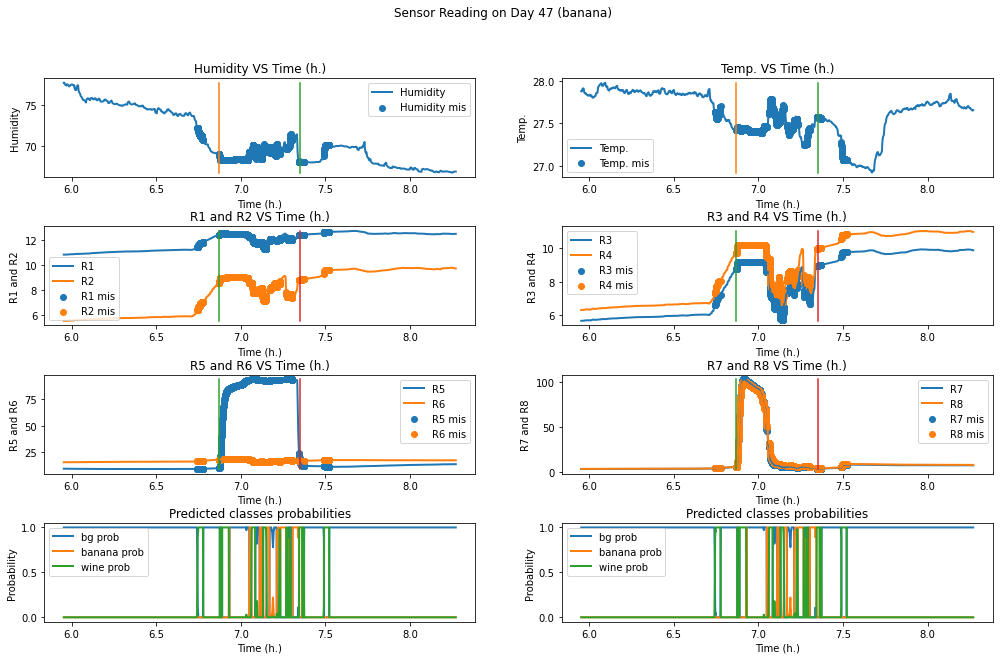

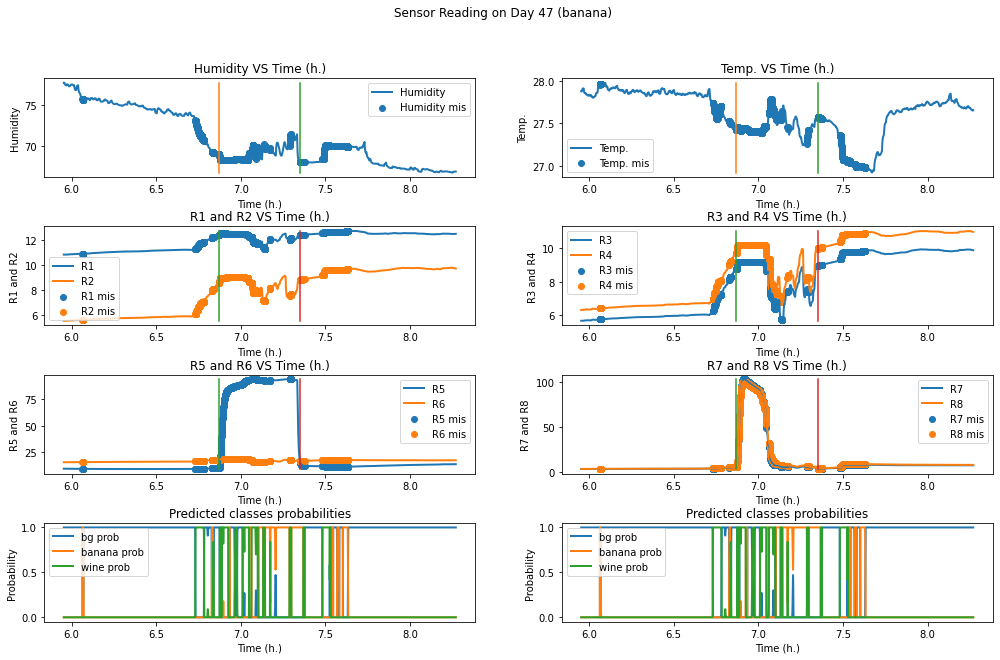

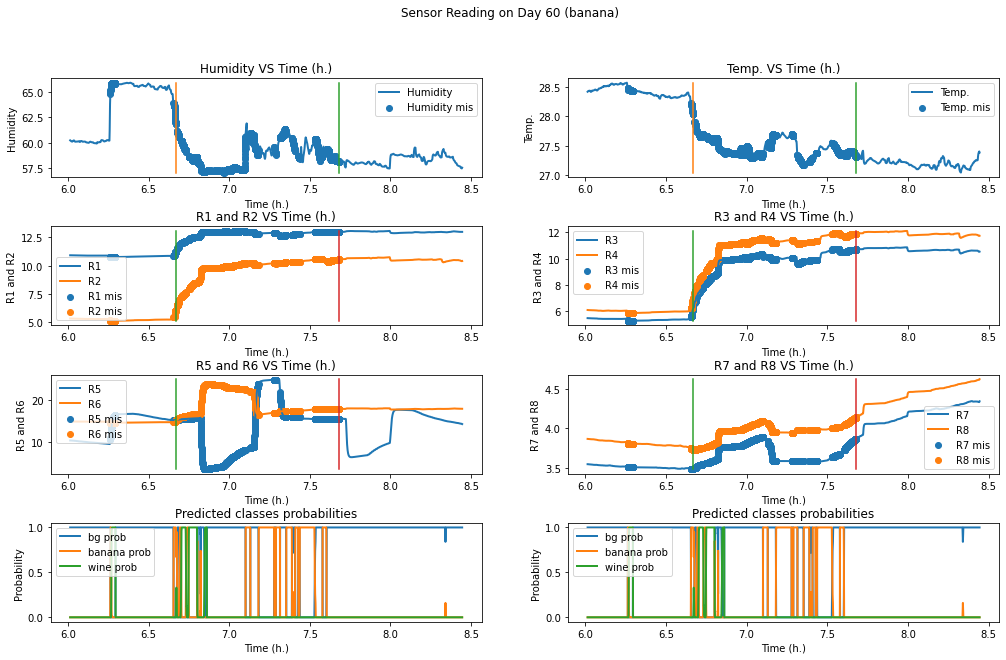

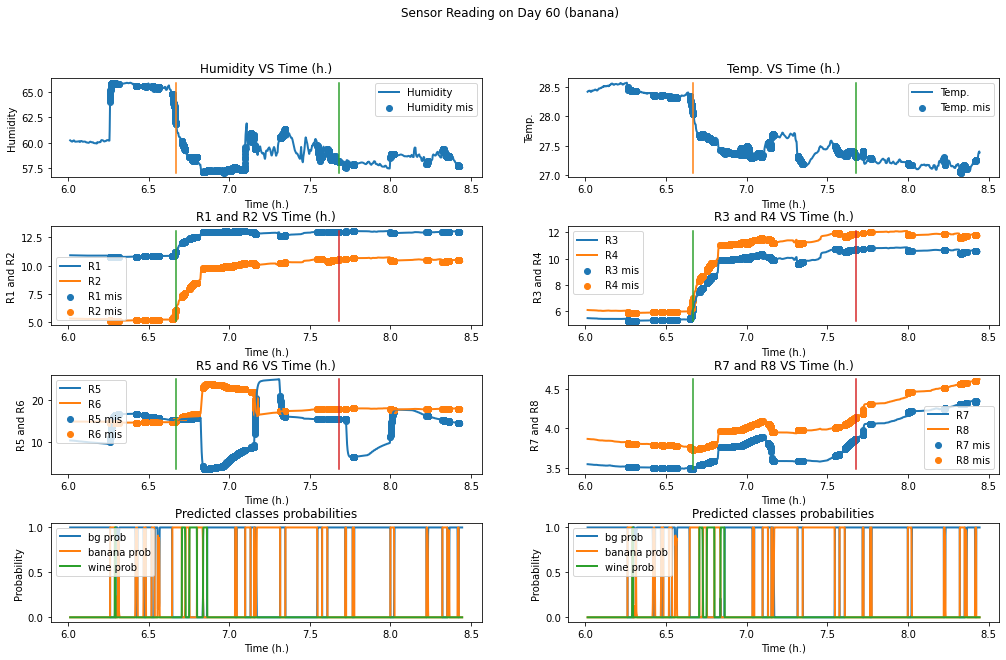

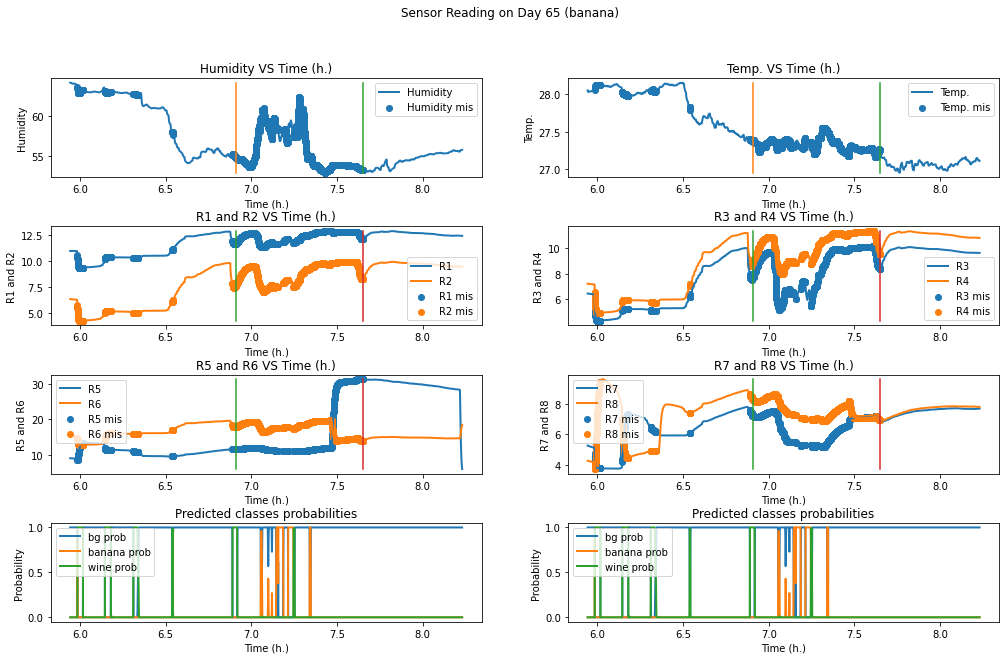

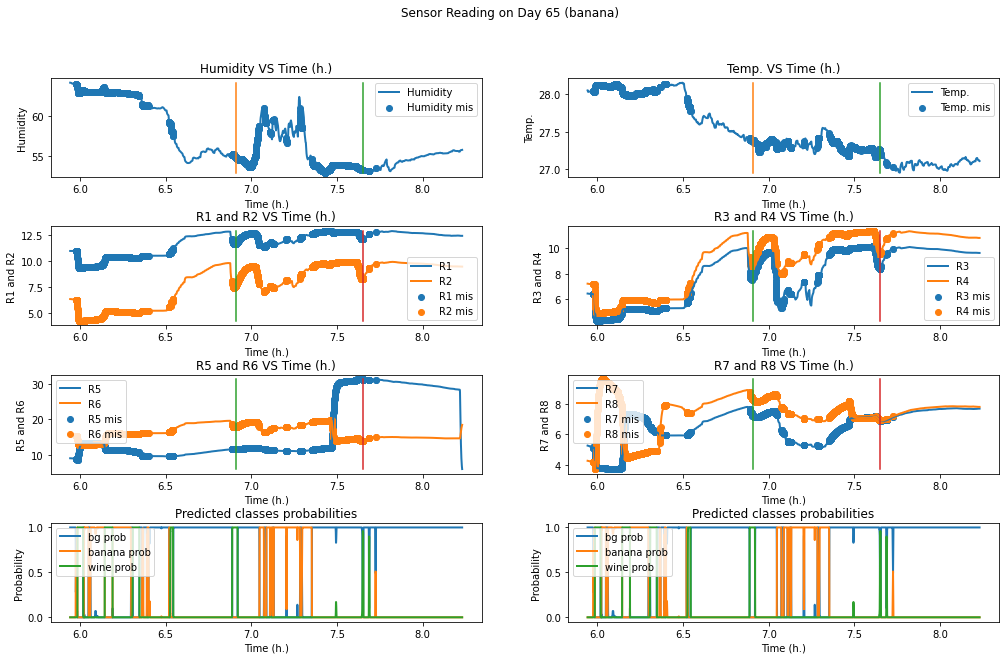

In [31]:
tids = [15, 17, 21, 22, 27, 30, 47, 60, 65]
for tid in tids:
    plot_misclassified_byID(df_test, tid, ytest, y_pred, probs_mtx=probs)
    plot_misclassified_byID(df_test, tid, ytest, y_pred_smote, probs_mtx=probs_smote)

In [33]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

df_train, df_test = split_series_byID(0.8, win_df)


xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

In [34]:
chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
bc = BaggingClassifier(base_estimator=clf, n_estimators=100, n_jobs=-1)

X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = bc.fit(X_features, ytrain)


X_features = chi2_feature.fit_transform(xtest, ytest)


y_pred = clf.predict(X_features)
metric_report(ytest, y_pred)

TEST SET PROPORTIONS:
	Real background percentage: 0.7462679592292395
	Real banana percentage: 0.09550908930416586
	Real wine percentage: 0.15822295146659465
------------------------------------------
Accuracy: 0.8676352231955096
Recall on background: 0.9408375834069703
Recall on banana: 0.18527780798086332
Recall on wine: 0.9342675242845891
F1-score: 0.8490961013362209


In [35]:
probs = clf.predict_proba(X_features)

In [36]:
test_ids = list(set(df_test['id']))
print(test_ids)

[2, 3, 22, 25, 36, 38, 39, 46, 51, 54, 55, 58, 74, 76, 78, 79, 81, 84, 88, 89]


In [37]:
# SMOTE
over_dict = {'banana': 175000, 'wine': 175000}
under_dict = {'background': 500000}

oversample = SMOTE(sampling_strategy=over_dict)
undersample = RandomUnderSampler(sampling_strategy=under_dict)
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)
xtrain, ytrain = undersample.fit_resample(xtrain, ytrain)

chi2_feature_smote = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
clf_smote = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
bc_smote = BaggingClassifier(base_estimator=clf_smote, n_estimators=100, n_jobs=-1)

X_features_smote = chi2_feature_smote.fit_transform(xtrain, ytrain)
clf_sm = bc_smote.fit(X_features_smote, ytrain)


X_features_smote = chi2_feature_smote.fit_transform(xtest, ytest)


y_pred_smote = clf_sm.predict(X_features_smote)
metric_report(ytest, y_pred_smote)

TEST SET PROPORTIONS:
	Real background percentage: 0.7462679592292395
	Real banana percentage: 0.09550908930416586
	Real wine percentage: 0.15822295146659465
------------------------------------------
Accuracy: 0.8495552705502392
Recall on background: 0.8868865804359776
Recall on banana: 0.3989888006958791
Recall on wine: 0.9454581254922552
F1-score: 0.8488128309258204


In [38]:
probs_smote = clf_sm.predict_proba(X_features_smote)

In [39]:
test_ids_sm = list(set(df_test['id']))
print(test_ids_sm)

[2, 3, 22, 25, 36, 38, 39, 46, 51, 54, 55, 58, 74, 76, 78, 79, 81, 84, 88, 89]


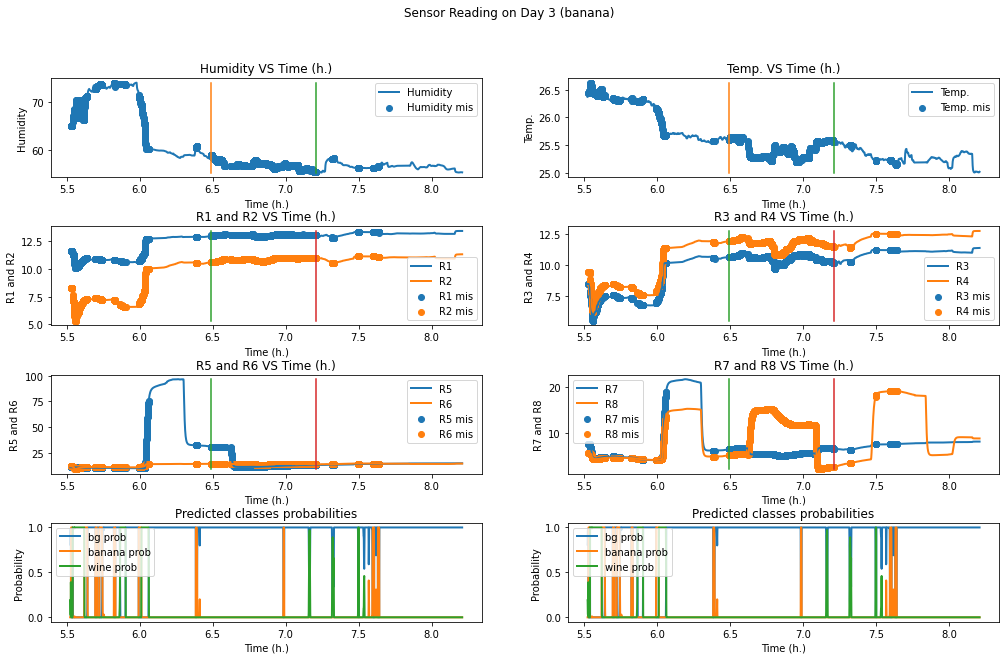

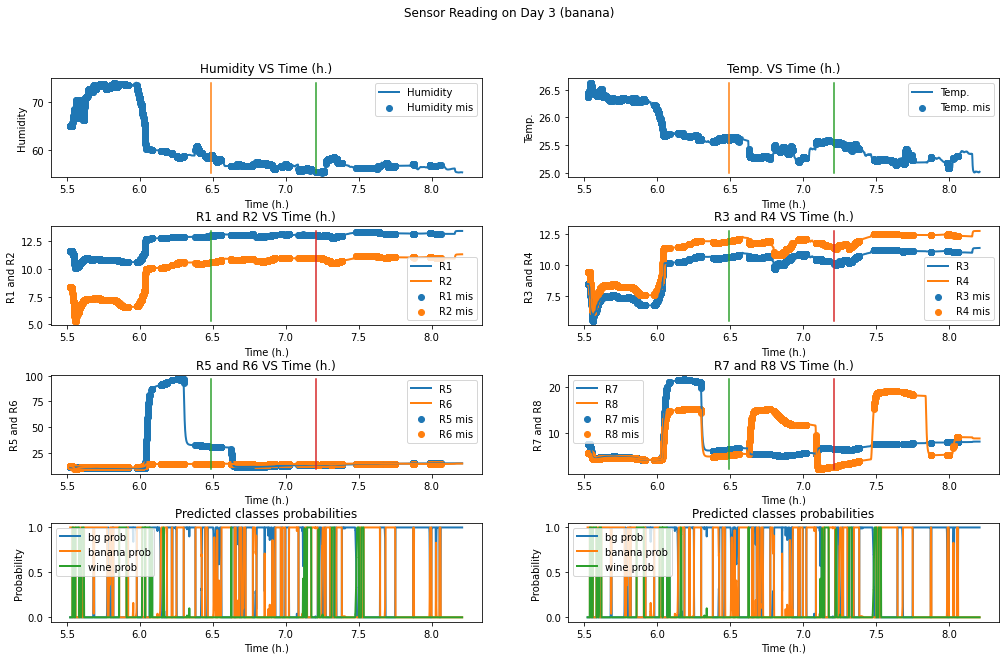

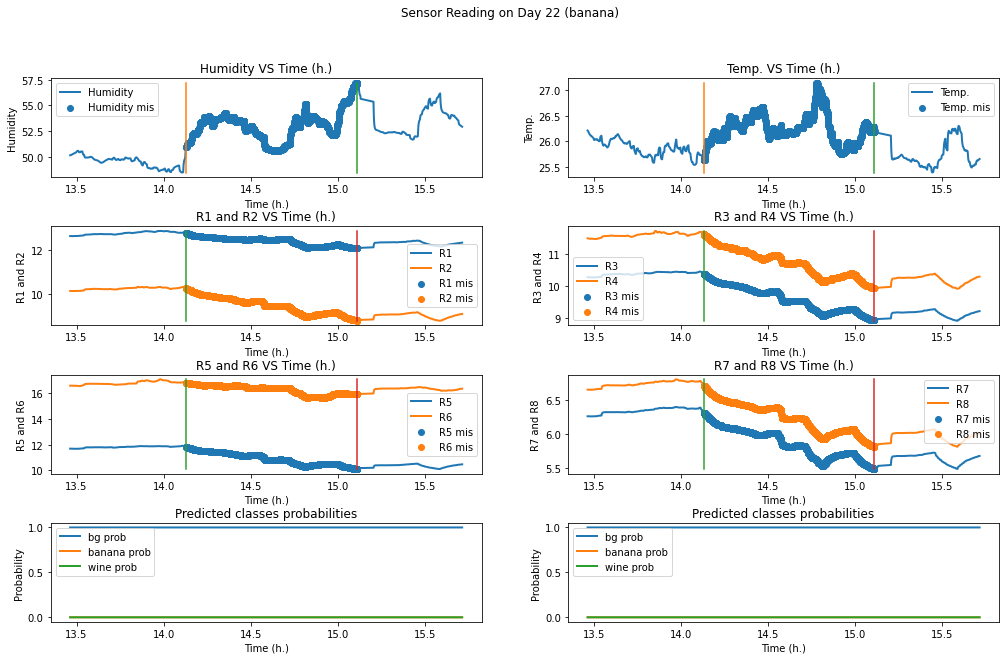

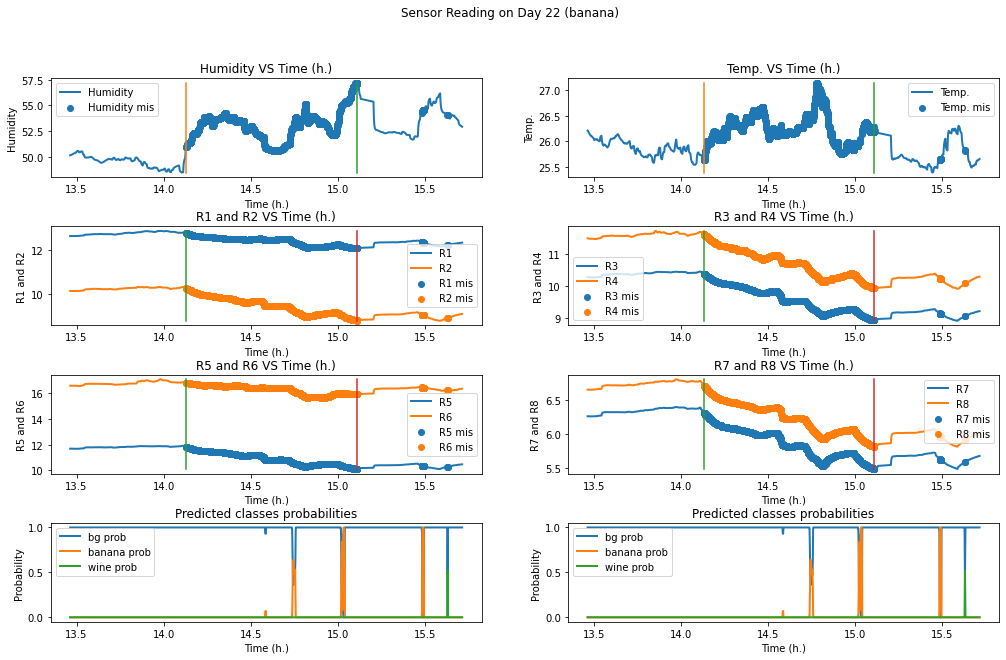

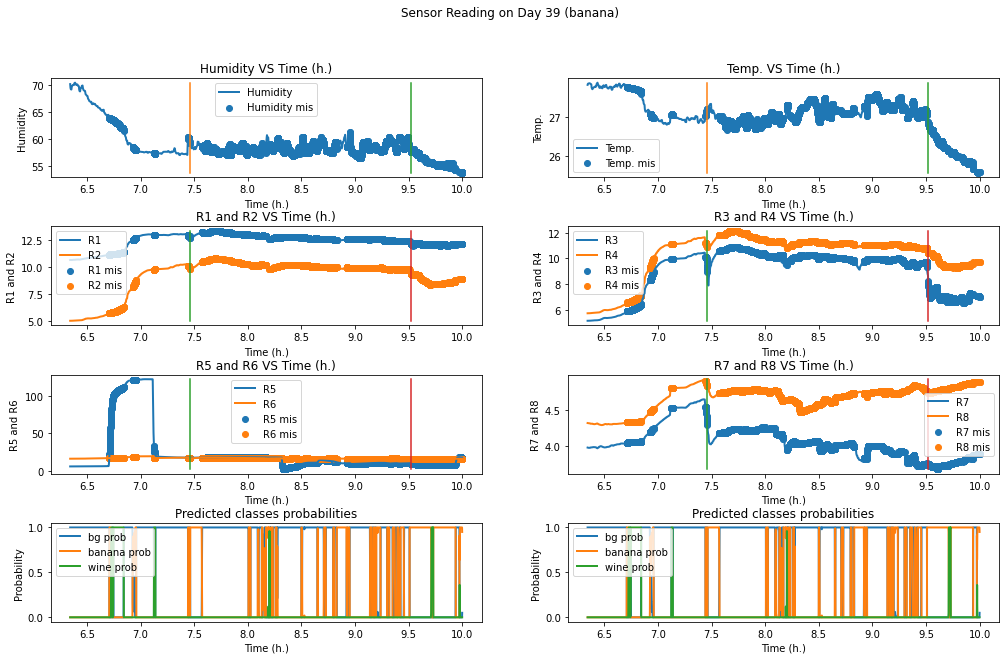

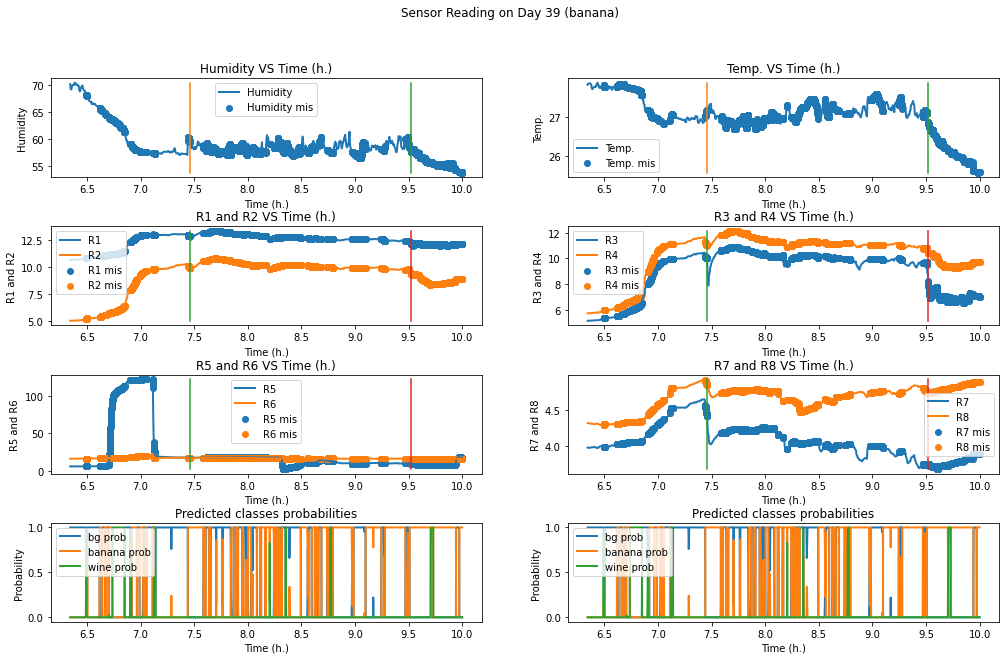

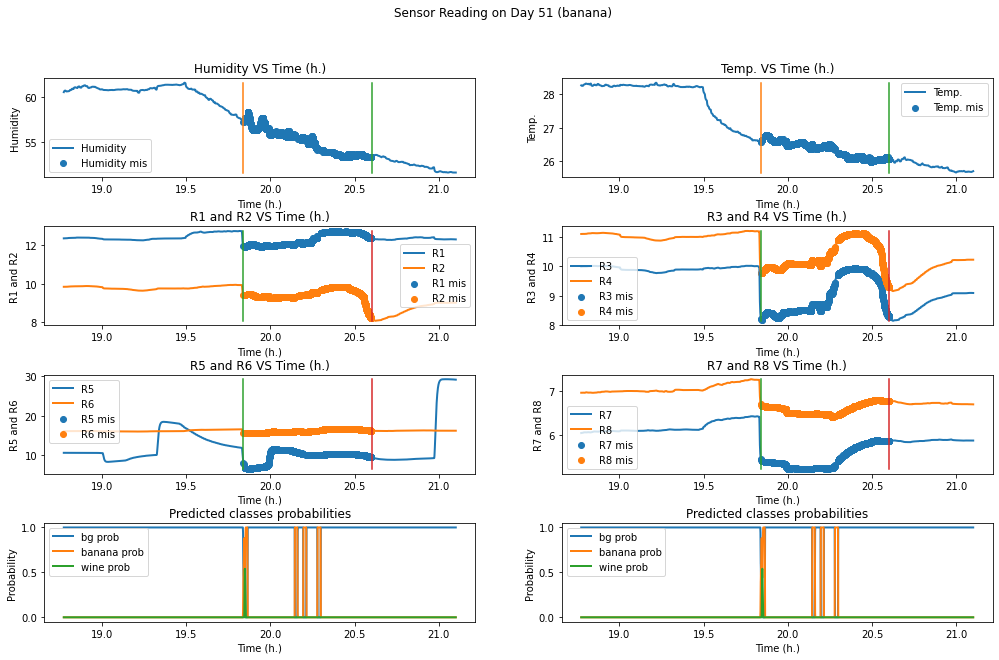

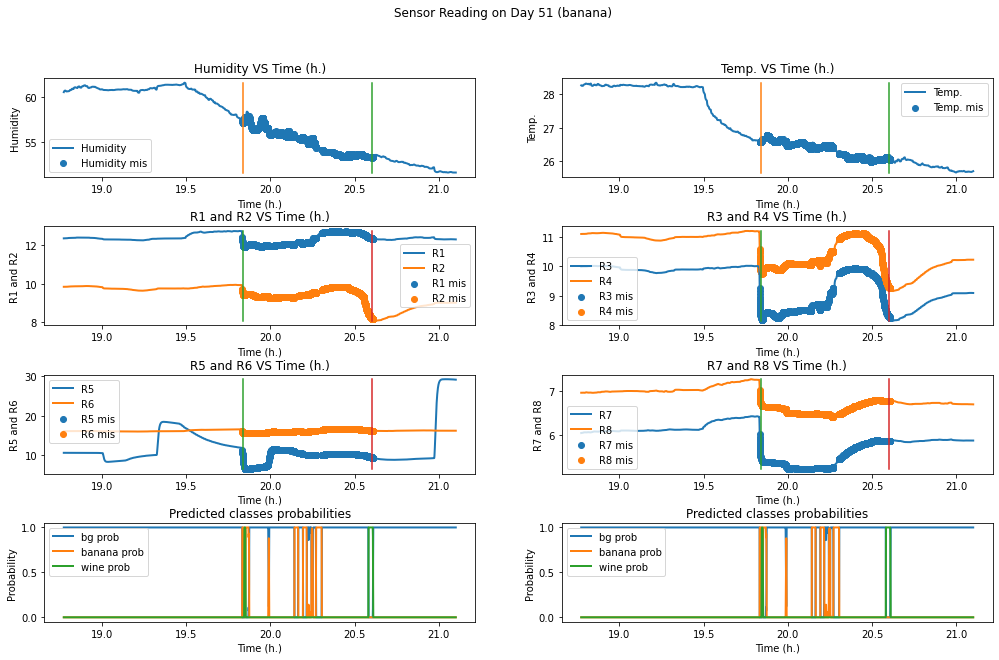

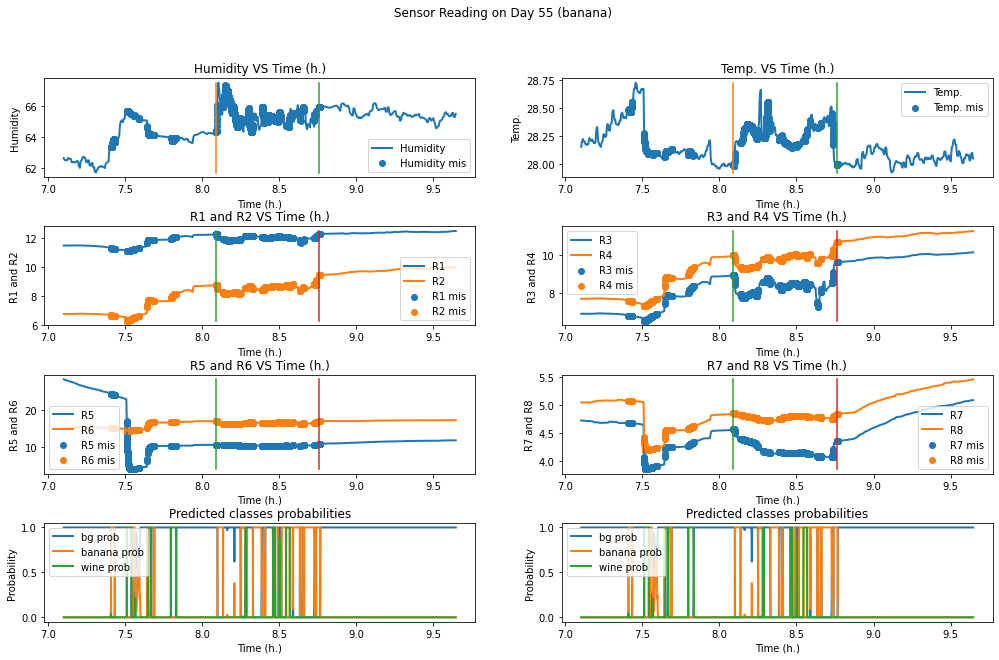

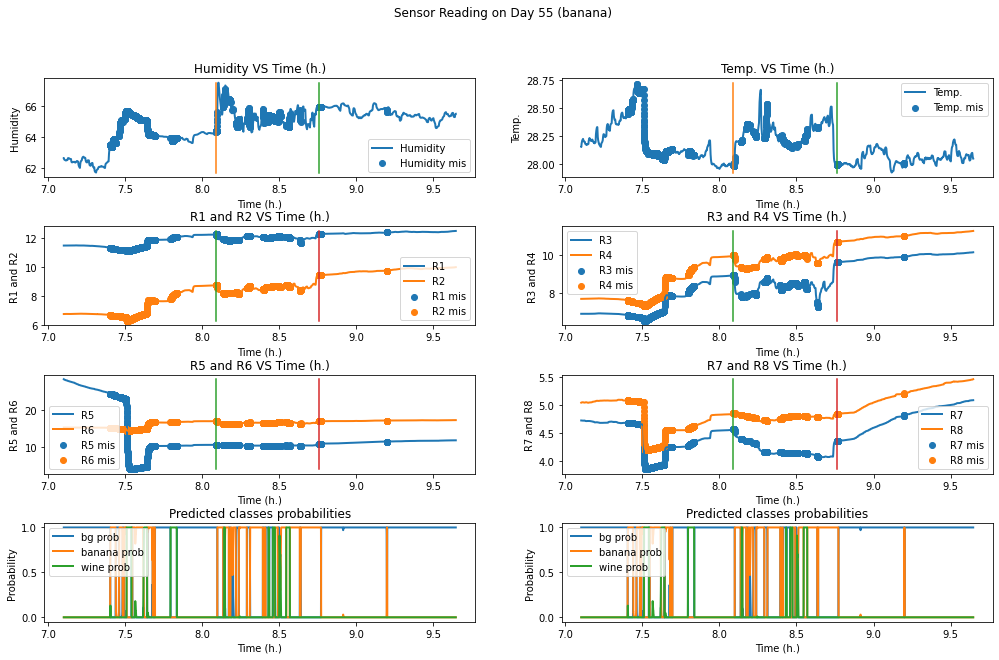

In [40]:
tids = [3, 22, 39, 51, 55]
for tid in tids:
    plot_misclassified_byID(df_test, tid, ytest, y_pred, probs_mtx=probs)
    plot_misclassified_byID(df_test, tid, ytest, y_pred_smote, probs_mtx=probs_smote)